In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
register_matplotlib_converters()

# Generate Some Data

In this case, we're going to generate a pure moving average process d

# $y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t$
# $\varepsilon_t \sim N(0,1)$

In [2]:
errors = np.random.normal(0, 1, 400)

In [3]:
date_index = pd.date_range(start='9/1/2019', end='1/1/2020')

In [4]:
mu = 50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

In [5]:
series = pd.Series(series, date_index)
# infer the frequency
series = series.asfreq(pd.infer_freq(series.index))

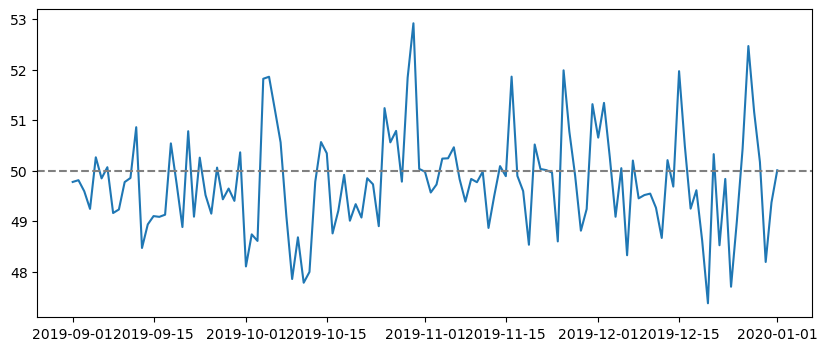

In [6]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.axhline(mu, linestyle='--', color='grey')

In [16]:
def calc_corr(series, lag):
    return pearsonr(series[:-lag], series[lag:])[0]

# ACF

<BarContainer object of 10 artists>

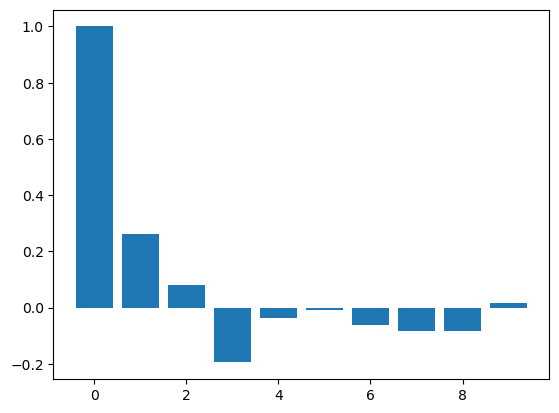

In [25]:
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])

# PACF

<BarContainer object of 25 artists>

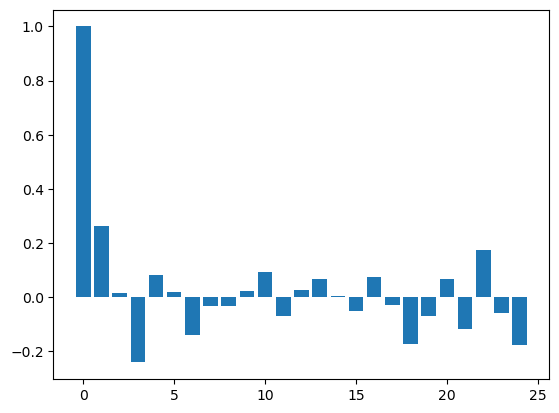

In [31]:
pacf_vals = pacf(series,25)
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])

# Get training and testing sets

In [32]:
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

# Fit ARIMA Model

In [33]:
#create the model
model = ARIMA(train_data, order=(0,0,2))

In [34]:
#fit the model
model_fit = model.fit()

In [35]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -183.165
Date:                Sat, 11 Mar 2023   AIC                            374.331
Time:                        17:04:50   BIC                            385.514
Sample:                    09-01-2019   HQIC                           378.873
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.2667      0.152    330.881      0.000      49.969      50.564
ma.L1          0.3253      0.092      3.552      0.000       0.146       0.505
ma.L2          0.2021      0.097      2.093      0.0

# Predicted Model:
# $\hat{y}_t = 50 + 0.37\varepsilon_{t-1} + 0.25\varepsilon_{t-2}$

In [36]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [37]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [38]:
residuals = test_data - predictions

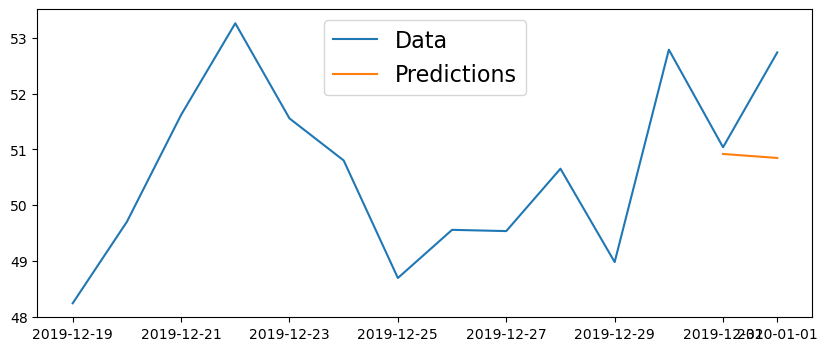

In [39]:
plt.figure(figsize=(10,4))

plt.plot(series[-14:])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [40]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0191


In [41]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.3420181003723795
